In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
import numpy as np


In [2]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [3]:
import re
from collections import defaultdict

def get_patient_id(filename):
    match = re.search(r'patient_(\d+)_', filename)
    return int(match.group(1)) if match else -1

def load_data_by_patient_nested(dataset_root):
    patient_to_images = defaultdict(list)
    patient_labels = {}

    # Iterate through top-level folders (e.g., NC, MCI)
    for main_folder in os.listdir(dataset_root):
        main_path = os.path.join(dataset_root, main_folder)
        if not os.path.isdir(main_path):
            continue

        # Assign label based on folder name (1 for MCI, 0 for NC)
        label = 1 if main_folder == 'MCI' else 0

        # Iterate through files in the folder
        for fname in os.listdir(main_path):
            fpath = os.path.join(main_path, fname)
            if os.path.isfile(fpath):
                match = re.search(r'patient_(\d+)_', fname)
                if match:
                    pid = int(match.group(1))
                    patient_to_images[pid].append(fpath)
                    patient_labels[pid] = label

    return patient_to_images, patient_labels


In [4]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split

def create_folds(patient_to_images, patient_labels, transform, k=5):
    patient_ids = list(patient_to_images.keys())
    patient_y = [patient_labels[pid] for pid in patient_ids]

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    folds = []

    for train_idx, val_idx in skf.split(patient_ids, patient_y):
        train_img_paths, train_labels = [], []
        val_img_paths, val_labels = [], []

        for i in train_idx:
            pid = patient_ids[i]
            train_img_paths += patient_to_images[pid]
            train_labels += [patient_labels[pid]] * len(patient_to_images[pid])

        for i in val_idx:
            pid = patient_ids[i]
            val_img_paths += patient_to_images[pid]
            val_labels += [patient_labels[pid]] * len(patient_to_images[pid])

        train_dataset = EEGDataset(train_img_paths, train_labels, transform)
        val_dataset = EEGDataset(val_img_paths, val_labels, transform)

        folds.append((train_dataset, val_dataset))

    return folds

def create_train_test_split_all_bands(patient_to_images, patient_labels, transform, test_size=0.2):
    patient_ids = list(patient_to_images.keys())
    patient_y = [patient_labels[pid] for pid in patient_ids]

    # Keep all images without filtering for specific bands
    all_images = patient_to_images

    # Filter out patients with no images
    filtered_pids = [pid for pid in patient_ids if len(all_images[pid]) > 0]
    filtered_y = [patient_labels[pid] for pid in filtered_pids]

    # Split patient_ids into train and test sets
    train_idx, test_idx = train_test_split(
        range(len(filtered_pids)),
        test_size=test_size,
        stratify=filtered_y,
        random_state=42
    )

    # Create lists of image paths and labels for train set
    train_img_paths, train_labels = [], []
    for i in train_idx:
        pid = filtered_pids[i]
        train_img_paths += all_images[pid]
        train_labels += [patient_labels[pid]] * len(all_images[pid])

    # Create lists of image paths and labels for test set
    test_img_paths, test_labels = [], []
    for i in test_idx:
        pid = filtered_pids[i]
        test_img_paths += all_images[pid]
        test_labels += [patient_labels[pid]] * len(all_images[pid])

    # Create datasets for train and test
    train_dataset = EEGDataset(train_img_paths, train_labels, transform)
    test_dataset = EEGDataset(test_img_paths, test_labels, transform)

    return train_dataset, test_dataset

In [5]:
from torchvision import models
import torch.nn as nn
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def get_pretrained_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.fc.in_features, 2)
    )
    return model

class CAMModel(nn.Module):
    def __init__(self, model):
        super(CAMModel, self).__init__()
        self.resnet = model
        self.features = nn.Sequential(*list(model.children())[:-2])  # Extract features up to last conv layer
        self.avgpool = model.avgpool
        self.fc = model.fc
        self.last_conv_layer = list(model.children())[-3][-1]  # Last block of ResNet18 layer4

    def forward(self, x):
        x = self.features(x)
        feature_maps = x
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x, feature_maps

    def get_cam(self, feature_maps, weights, class_idx, input_size=(224, 224)):
        batch_size, channels, h, w = feature_maps.size()
        cam = weights[class_idx].unsqueeze(0) @ feature_maps.view(batch_size, channels, -1)
        cam = cam.view(batch_size, h, w)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = F.interpolate(cam.unsqueeze(0), size=input_size, mode='bilinear', align_corners=False)
        return cam.squeeze().cpu().numpy()

def visualize_cam(image, cam, save_path, alpha=0.4):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5 + 0.5) * 255  # Denormalize
    image = image.astype(np.uint8)
    
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    superimposed_img = heatmap * alpha + image / 255
    superimposed_img = superimposed_img / np.max(superimposed_img)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

def train_model(model, train_loader, val_loader, device, cam_output_dir="cam_outputs"):
    import os
    os.makedirs(cam_output_dir, exist_ok=True)
    
    cam_model = CAMModel(model).to(device)
    optimizer = torch.optim.Adam(cam_model.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0

    # Get weights of the final FC layer for CAM
    fc_weights = cam_model.fc[1].weight.data  # Shape: [2, 512]

    for epoch in range(30):
        cam_model.train()
        total, correct = 0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out, _ = cam_model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        val_acc = evaluate(cam_model, val_loader, device, cam_output_dir, fc_weights,epoch)
        print(f"Epoch {epoch+1} | Train Acc: {correct/total:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(cam_model.resnet.state_dict(), "best_model_fold.pth")
    return cam_model
def evaluate(model, loader, device, cam_output_dir, fc_weights, epoch):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            out, feature_maps = model(X)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            # Generate CAM for first image in batch
            if batch_idx == 0:  # Only for first batch to avoid too many images
                for i in range(min(3, X.size(0))):  # Visualize up to 3 images
                    cam = model.get_cam(feature_maps[i:i+1], fc_weights, pred[i].item())
                    visualize_cam(X[i], cam, f"{cam_output_dir}/cam_epoch_{epoch+1}_img_{i}.png")

    return correct / total

In [6]:
dataset_root = '/kaggle/input/newdata/newdata'
patient_to_images, patient_labels = load_data_by_patient_nested(dataset_root)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset, val_dataset = create_train_test_split_all_bands(patient_to_images, patient_labels, transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = get_pretrained_model()
model = train_model(model, train_loader, val_loader, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


Epoch 1 | Train Acc: 0.5759 | Val Acc: 0.5686
Epoch 2 | Train Acc: 0.6073 | Val Acc: 0.5244
Epoch 3 | Train Acc: 0.6543 | Val Acc: 0.5679
Epoch 4 | Train Acc: 0.7075 | Val Acc: 0.5551
Epoch 5 | Train Acc: 0.7622 | Val Acc: 0.5474
Epoch 6 | Train Acc: 0.8118 | Val Acc: 0.5449
Epoch 7 | Train Acc: 0.8660 | Val Acc: 0.5026
Epoch 8 | Train Acc: 0.9007 | Val Acc: 0.4833
Epoch 9 | Train Acc: 0.9187 | Val Acc: 0.5135
Epoch 10 | Train Acc: 0.9431 | Val Acc: 0.5205
Epoch 11 | Train Acc: 0.9502 | Val Acc: 0.5321
Epoch 12 | Train Acc: 0.9564 | Val Acc: 0.5237
Epoch 13 | Train Acc: 0.9635 | Val Acc: 0.5173
Epoch 14 | Train Acc: 0.9576 | Val Acc: 0.5308
Epoch 15 | Train Acc: 0.9655 | Val Acc: 0.5538
Epoch 16 | Train Acc: 0.9769 | Val Acc: 0.5173
Epoch 17 | Train Acc: 0.9806 | Val Acc: 0.5474
Epoch 18 | Train Acc: 0.9714 | Val Acc: 0.5288
Epoch 19 | Train Acc: 0.9595 | Val Acc: 0.5071
Epoch 20 | Train Acc: 0.9807 | Val Acc: 0.5205
Epoch 21 | Train Acc: 0.9832 | Val Acc: 0.5391
Epoch 22 | Train Acc: 

In [7]:
import torch.nn.functional as F

def get_predictions(model, test_dataset, batch_size=32):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs,f = model(images)  # Đầu ra là logits
            pred = outputs.argmax(1)  # Lấy xác suất lớp dương (1) cho bài toán nhị phân
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

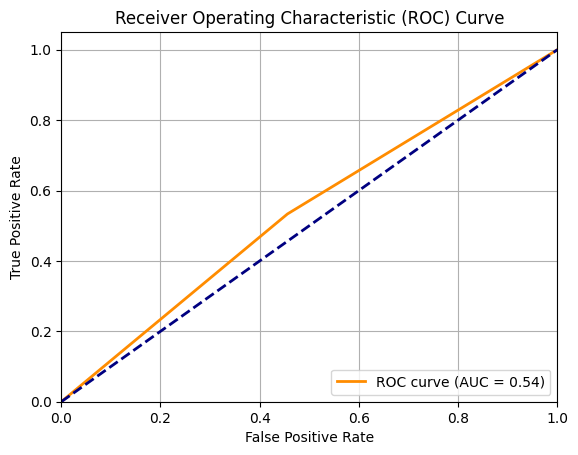

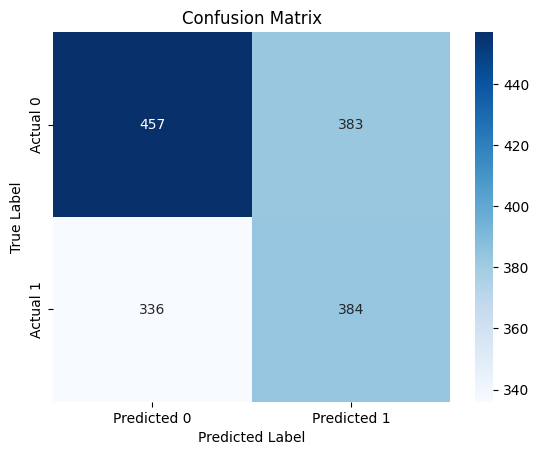

Sensitivity (Recall): 0.53
Specificity: 0.54
Precision: 0.50
F1 Score: 0.52
AUC: 0.54


In [8]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Lấy dự đoán xác suất và nhãn thực
y_true, y_pred_proba = get_predictions(model, val_dataset)
y_pred = (y_pred_proba > 0.5).astype(int)

# Tính confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Tính các chỉ số đánh giá
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

# ROC và AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Vẽ ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc2d.png', bbox_inches='tight')
plt.show()

# Vẽ Confusion Matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

# In kết quả
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"AUC: {roc_auc:.2f}")


In [9]:
def visualize_cam2(image, cam,i, alpha=0.4):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 0.5 + 0.5) * 255  # Denormalize
    image = image.astype(np.uint8)
    
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    superimposed_img = heatmap * alpha + image / 255
    superimposed_img = superimposed_img / np.max(superimposed_img)
    
    plt.figure(figsize=(6, 6))
    plt.subplot(1,2,1)
    plt.imshow(superimposed_img), plt.axis('off'),plt.title("CAM-image")
    plt.subplot(1,2,2)
    plt.imshow(image), plt.axis('off'),plt.title('Original image')
    # plt.show()
    plt.savefig(f'cam2{i}.png', bbox_inches='tight')
    plt.close()
    
def draw_cam_evaluate(model, loader, device='cuda'):
    fc_weights = model.fc[1].weight.data  
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            out, feature_maps = model(X)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            if batch_idx == 0:  # Only for first batch to avoid too many images
                for i in range(min(4, X.size(0))):  # Visualize up to 3 images
                    cam = model.get_cam(feature_maps[i:i+1], fc_weights, pred[i].item())
                    visualize_cam2(X[i], cam,i)

    return correct / total
draw_cam_evaluate(model,val_loader)

0.5391025641025641